In [109]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Compose, ToTensor
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import os
import librosa
import matplotlib.pyplot as plt

In [110]:
# waveform function for me to not bang my keyboard
def disp_waveform(signal, sr=None):
    plt.figure(figsize=(7,2))
    return librosa.display.waveshow(signal, sr=sr)

## Data preprocessing for helloworld.wav (testing, optional to run)

In [111]:
sample0, sr0 = librosa.load("wav/Hello World 2.wav")


In [112]:
sr0

22050

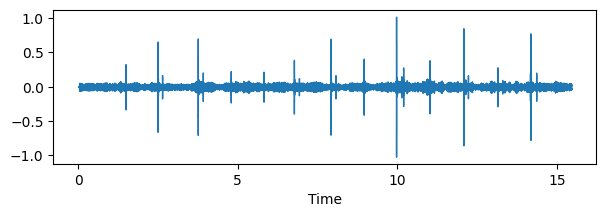

In [113]:
plt.figure(figsize=(7,2))
librosa.display.waveshow(sample0, sr=sr0)

In [114]:
# Unified parameters (run this once)
n_fft = 1024
hop_length = 256
before = 2400
after = 5000

# threshold percentile used inside isolator when threshold=None
threshold_percentile = 96


In [115]:
#Calculating the STFT of the Sample
fft = librosa.stft(sample0, n_fft = n_fft , hop_length = hop_length)

In [116]:
#Calculating the Energy of the Signal using FFT
#energy = np.abs(np.sum(fft, axis=0)).astype(float)
energy = np.sum(np.abs(fft)**2, axis=0)   # power 합 (표준)


In [117]:
len(energy), len(sample0), len(fft)

(1331, 340570, 513)

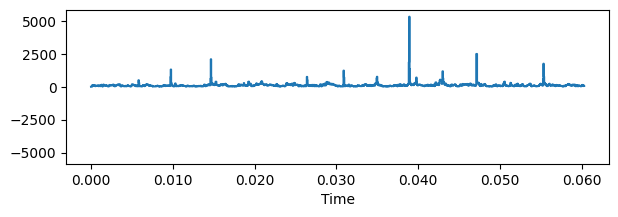

In [118]:
plt.figure(figsize=(7,2))
librosa.display.waveshow(energy)

In [119]:
#threshold = 0.9
threshold = np.percentile(energy, threshold_percentile)   # 95~99 사이로 조절
#med = np.median(energy)
#mad = np.median(np.abs(energy - med))
#threshold = med + 6 * mad   # 6~10 범위로 조절

#Converting into Binary
threshed = energy > threshold

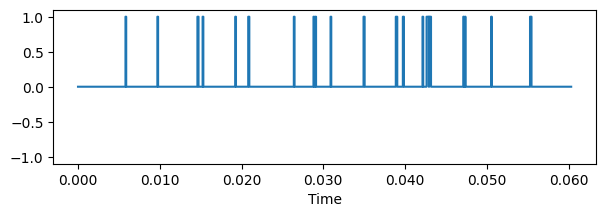

In [120]:
plt.figure(figsize=(7,2))
librosa.display.waveshow(threshed.astype(float))

In [121]:
peaks = np.where(threshed == True)[0]
print(peaks)

[ 128  129  214  215  322  323  324  336  337  424  425  459  460  461
  582  583  635  636  640  641  681  682  770  771  772  857  858  859
  860  876  877  878  929  930  940  941  942  943  944  945  947  948
  949  950  951 1039 1040 1044 1114 1115 1219 1220 1221 1222]


In [122]:
peak_count = len(peaks)
print(peak_count)

54


In [123]:
prev_end = sr0*0.1*(-1)

In [124]:
strokes = []

/var/folders/mz/2wl7n1990lv2x93xqyw579x80000gn/T/ipykernel_84062/798190620.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(7, 2))


<Figure size 700x200 with 0 Axes>

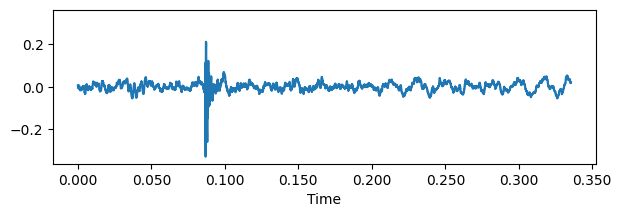

<Figure size 700x200 with 0 Axes>

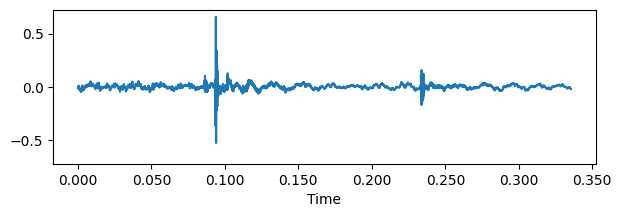

<Figure size 700x200 with 0 Axes>

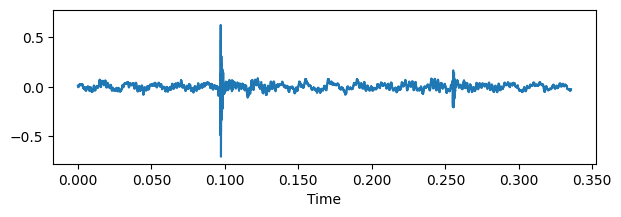

<Figure size 700x200 with 0 Axes>

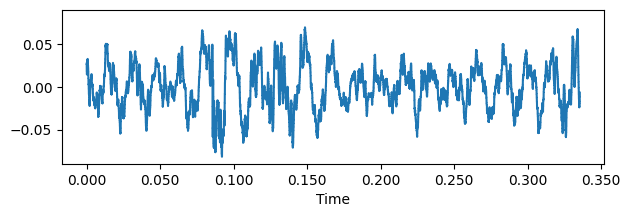

<Figure size 700x200 with 0 Axes>

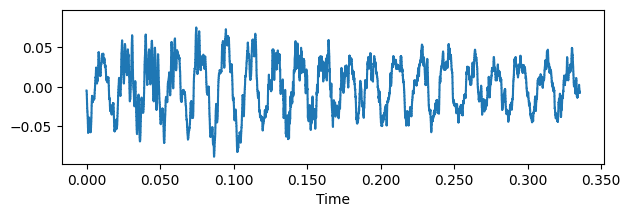

<Figure size 700x200 with 0 Axes>

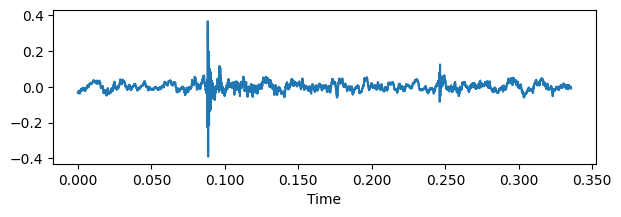

<Figure size 700x200 with 0 Axes>

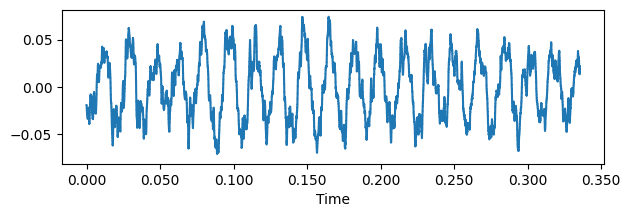

<Figure size 700x200 with 0 Axes>

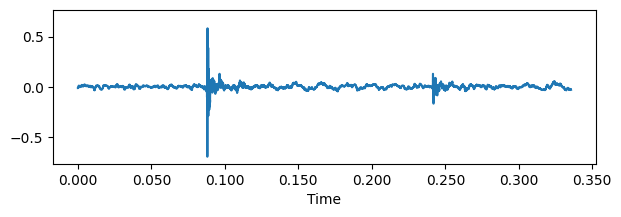

<Figure size 700x200 with 0 Axes>

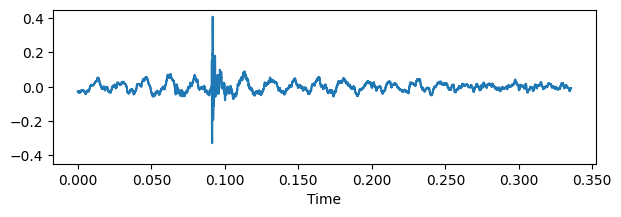

<Figure size 700x200 with 0 Axes>

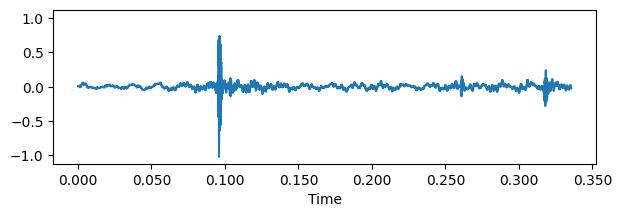

<Figure size 700x200 with 0 Axes>

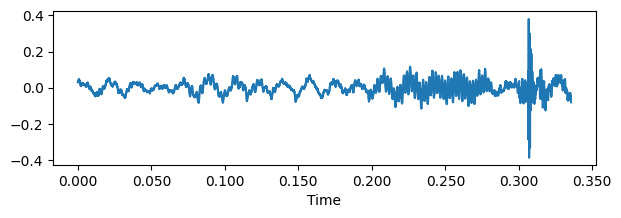

<Figure size 700x200 with 0 Axes>

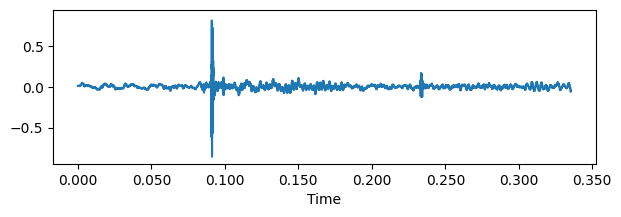

<Figure size 700x200 with 0 Axes>

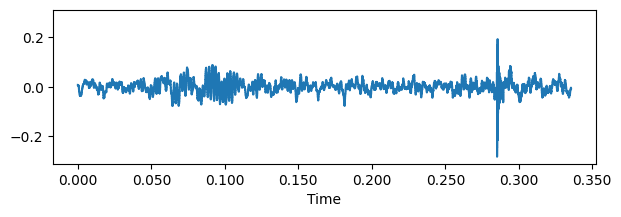

<Figure size 700x200 with 0 Axes>

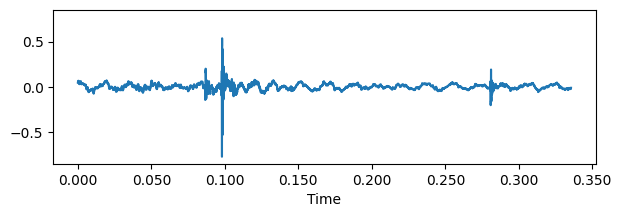

In [125]:


for i in range(peak_count):
  this_peak = peaks[i]
  timestamp = (this_peak*hop_length) + n_fft//2
  if timestamp > prev_end + (0.1 * sr0):
    keystroke = sample0[timestamp-before:timestamp+after]
    strokes.append(torch.tensor(keystroke)[None, :])
    plt.figure(figsize=(7, 2))
    disp_waveform(keystroke, sr=sr0)
    prev_end = timestamp+after

In [126]:
strokes

[tensor([[ 0.0055,  0.0027, -0.0008,  ...,  0.0205,  0.0211,  0.0212]]),
 tensor([[-0.0149, -0.0127, -0.0092,  ..., -0.0236, -0.0236, -0.0230]]),
 tensor([[ 0.0108,  0.0085,  0.0072,  ..., -0.0264, -0.0260, -0.0245]]),
 tensor([[ 0.0270,  0.0219,  0.0183,  ..., -0.0149, -0.0113, -0.0069]]),
 tensor([[-0.0048, -0.0077, -0.0102,  ..., -0.0061, -0.0060, -0.0075]]),
 tensor([[-0.0351, -0.0349, -0.0339,  ..., -0.0106, -0.0097, -0.0087]]),
 tensor([[-0.0194, -0.0220, -0.0236,  ...,  0.0150,  0.0183,  0.0216]]),
 tensor([[-0.0133, -0.0121, -0.0126,  ..., -0.0287, -0.0300, -0.0311]]),
 tensor([[-0.0263, -0.0273, -0.0275,  ..., -0.0100, -0.0092, -0.0085]]),
 tensor([[ 0.0082,  0.0083,  0.0083,  ..., -0.0127, -0.0194, -0.0254]]),
 tensor([[ 0.0298,  0.0326,  0.0343,  ..., -0.0693, -0.0767, -0.0806]]),
 tensor([[ 0.0099,  0.0104,  0.0111,  ..., -0.0524, -0.0495, -0.0490]]),
 tensor([[ 0.0075,  0.0059,  0.0048,  ..., -0.0039, -0.0051, -0.0065]]),
 tensor([[ 0.0436,  0.0482,  0.0539,  ..., -0.0168,

In [127]:
print("peaks:", len(peaks))
print("strokes:", len(strokes))


peaks: 54
strokes: 14


In [128]:
spect = librosa.feature.melspectrogram(y=np.asarray(strokes[0]), n_mels=64, hop_length=225)


In [129]:
def isolator(signal, sample_rate, n_fft, hop_length, before, after, threshold=None, show=False):
    strokes = []
    # -- signal'
    if show:
        disp_waveform(signal, sr=sample_rate)
    fft = librosa.stft(signal, n_fft=n_fft, hop_length=hop_length)
    energy = np.sum(np.abs(fft)**2, axis=0)   # power 합 (표준)
    # threshold auto from same signal unless provided
    if threshold is None:
        threshold = np.percentile(energy, threshold_percentile)
    # -- energy'
    if show:
        disp_waveform(energy)
    threshed = energy > threshold
    # -- peaks'
    if show:
        disp_waveform(threshed.astype(float))
    peaks = np.where(threshed == True)[0]
    peak_count = len(peaks)
    prev_end = sample_rate*0.1*(-1)
    # '-- isolating keystrokes'
    for i in range(peak_count):
        this_peak = peaks[i]
        timestamp = (this_peak*hop_length) + n_fft//2
        if timestamp > prev_end + (0.1*sample_rate):
            keystroke = signal[timestamp-before:timestamp+after]
            # strokes.append(torch.tensor(keystroke)[None, :])
            # keystroke = transform(keystroke)
            strokes.append(keystroke)
            if show:
                disp_waveform(keystroke, sr=sample_rate)
            prev_end = timestamp+after
    print("peaks:", len(peaks))
    print("strokes:", len(strokes))
    
    return strokes


In [130]:
def create_dataset(n_fft, hop_length, before, after):
    for i, File in enumerate(keys):
        loc = MBP_AUDIO_DIR + File
        samples, sr = librosa.load(loc, sr=None)
        # samples, sr = librosa.load(loc,sr=None,duration=1.0,mono=True)

        strokes = []
        thr = np.percentile(energy, 97) 
        step = 0.005
        strokes = isolator(samples[1*sr:], sr, n_fft, hop_length, before, after, thr, False )
        # while not len(strokes) == 25:
        #   strokes = isolator(samples[1*sr:], sr, n_fft, hop_length, before, after, prom, False )
        #   if len(strokes) < 25:
        #     prom -= step
        #   if len(strokes) > 25:
        #     prom += step
        #   if prom < 0:
        #     print("--not possible for : ", File)
        #     break
        #   step = step * 0.99
        label = [labels[i]]*len(strokes)
        data_dict['Key'] += label
        data_dict['File'] += strokes

    df = pd.DataFrame(data_dict)
    mapper = {}
    counter = 0
    for l in df['Key']:
        if not l in mapper:
            mapper[l] = counter
            counter += 1
    df.replace({'Key': mapper}, inplace = True)

    return df

## Generating MelSpectrograms

In [131]:
# Create mel-spectrogram images for test dataset keystrokes (sample settings)
from pathlib import Path
import matplotlib.pyplot as plt
import librosa.display

test_dir = Path('wav')
out_root = Path('out/test')
out_root.mkdir(parents=True, exist_ok=True)

# sample-style parameters
before = 2400
after = 5000

for wav_path in sorted(test_dir.glob('*.wav')):
    key = wav_path.stem
    samples, sr = librosa.load(wav_path.as_posix())

    print("file:", wav_path.name)
    print("sr:", sr, "len:", len(samples))
    print("n_fft:", n_fft, "hop:", hop_length, "before:", before, "after:", after)

    # isolate keystrokes with auto-threshold on the same signal
    strokes = isolator(samples, sr, n_fft, hop_length, before, after, threshold=None, show=False)
    key_out = out_root / key
    key_out.mkdir(parents=True, exist_ok=True)
    for i, stroke in enumerate(strokes):
        mel = librosa.feature.melspectrogram(
            y=np.asarray(stroke).squeeze(),
            sr=sr,
            n_mels=64,
            n_fft=1024,
            hop_length=225,
        )
        plt.figure(figsize=(6, 4))
        librosa.display.specshow(
            librosa.power_to_db(mel, ref=np.max),
            x_axis='time',
            y_axis='mel',
            sr=sr,
            hop_length=225,
        )
        plt.colorbar(format='%+2.0f dB')
        plt.title(f'Mel Spectrogram ({key}) - keystroke {i}')
        plt.tight_layout()
        plt.savefig(key_out / f'keystroke_{i:04d}.png', dpi=150)
        plt.close()


file: Hello World 2.wav
sr: 22050 len: 340570
n_fft: 1024 hop: 256 before: 2400 after: 5000
peaks: 54
strokes: 14
file: Hello World.wav
sr: 22050 len: 206976
n_fft: 1024 hop: 256 before: 2400 after: 5000
peaks: 33
strokes: 13
file: test.wav
sr: 22050 len: 335396
n_fft: 1024 hop: 256 before: 2400 after: 5000
peaks: 53
strokes: 24


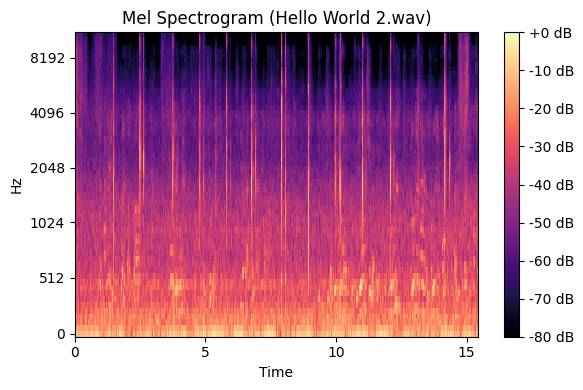

In [132]:
# Mel-spectrogram image for Hello World 2.wav
import matplotlib.pyplot as plt
import librosa.display
sample_hw2, sr_hw2 = librosa.load("wav/Hello World 2.wav")
mel_hw2 = librosa.feature.melspectrogram(
    y=sample_hw2, sr=sr_hw2, n_mels=64, n_fft=1024, hop_length=225
)
plt.figure(figsize=(6, 4))
librosa.display.specshow(librosa.power_to_db(mel_hw2, ref=np.max), x_axis='time', y_axis='mel', sr=sr_hw2, hop_length=225)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram (Hello World.wav)')
plt.tight_layout()
plt.show()
